In [2]:
# Library imports
import pyforest
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
from pprint import pprint
from time import sleep
import time
import seaborn as sns

from turtle import forward
import torch.nn as nn
import torch.nn.functional as F
import math
import torch
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.utils.data import DataLoader, TensorDataset

# **April 6, 2022**

#### **Function to create plots from results**

In [8]:
def makePlots(meta_file, base_file, plot_file, dataset = 'steam', save = True):
    meta = pd.read_csv(meta_file)
    base = pd.read_csv(base_file)
    meta = meta.drop(columns=['Unnamed: 0'])
    base = base.drop(columns=['Unnamed: 0'])

    # adjust index and headers
    meta = meta.reset_index()
    meta.columns = ['# Perturbations', 'Perturbed edge', 'Meta gradient', 'Accuracy including perturbed edges (surrogate)', 'Accuracy excluding perturbed edges (surrogate)', 'Loss including perturbed edges (surrogate)', 'Loss excluding perturbed edges (surrogate)', 'Accuracy including perturbed edges (target)', 'Accuracy excluding perturbed edges (target)', 'Loss including perturbed edges (target)', 'Loss excluding perturbed edges (target)']
    base = base.reset_index()
    base.columns = ['# Perturbations', 'Perturbed edge', 'Base gradient', 'Accuracy including perturbed edges (surrogate)', 'Accuracy excluding perturbed edges (surrogate)', 'Loss including perturbed edges (surrogate)', 'Loss excluding perturbed edges (surrogate)', 'Accuracy including perturbed edges (target)', 'Accuracy excluding perturbed edges (target)', 'Loss including perturbed edges (target)', 'Loss excluding perturbed edges (target)']

    # figure specifications
    sns.set_theme()
    figsize = (9, 7)

    # loss plot for meta
    plt.figure(figsize = figsize)
    sns.lineplot(data = meta, x = '# Perturbations', y = 'Loss excluding perturbed edges (surrogate)', color = 'blue').set_title('Comparison of loss for CF model ({})'.format('meta'))
    fig = sns.lineplot(data = meta, x = '# Perturbations', y = 'Loss excluding perturbed edges (target)', color = 'green').get_figure()
    plt.xlabel('Number of perturbations')
    plt.ylabel('Loss')
    plt.legend(labels = ['Loss (surrogate)', 'Loss (target)'], loc = 'upper left')
    if save:
        fig.savefig('plots/ppt/loss-meta-' + plot_file)
    plt.show()

    # loss plot for base
    plt.figure(figsize = figsize)
    sns.lineplot(data = base, x = '# Perturbations', y = 'Loss excluding perturbed edges (surrogate)', color = 'blue').set_title('Comparison of loss for CF model ({})'.format('base'))
    fig = sns.lineplot(data = base, x = '# Perturbations', y = 'Loss excluding perturbed edges (target)', color = 'green').get_figure()
    plt.xlabel('Number of perturbations')
    plt.ylabel('Loss')
    plt.legend(labels = ['Loss (surrogate)', 'Loss (target)'], loc = 'upper left')
    if save:
        fig.savefig('plots/ppt/loss-base-' + plot_file)
    plt.show()

    # accuracy plot for meta
    plt.figure(figsize = figsize)
    sns.lineplot(data = meta, x = '# Perturbations', y = 'Accuracy excluding perturbed edges (surrogate)', color = 'blue').set_title('Comparison of accuracy for CF model ({})'.format('meta'))
    fig = sns.lineplot(data = meta, x = '# Perturbations', y = 'Accuracy excluding perturbed edges (target)', color = 'green').get_figure()
    plt.xlabel('Number of perturbations')
    plt.ylabel('Accuracy')
    plt.legend(labels = ['Accuracy (surrogate)', 'Accuracy (target)'])
    if save:
        fig.savefig('plots/ppt/accuracy-meta-' + plot_file)
    plt.show()

    # accuracy plot for base
    plt.figure(figsize = figsize)
    sns.lineplot(data = base, x = '# Perturbations', y = 'Accuracy excluding perturbed edges (surrogate)', color = 'blue').set_title('Comparison of accuracy for CF model ({})'.format('base'))
    fig = sns.lineplot(data = base, x = '# Perturbations', y = 'Accuracy excluding perturbed edges (target)', color = 'green').get_figure()
    plt.xlabel('Number of perturbations')
    plt.ylabel('Accuracy')
    plt.legend(labels = ['Accuracy (surrogate)', 'Accuracy (target)'])
    if save:
        fig.savefig('plots/ppt/accuracy-base-' + plot_file)
    plt.show()


# **April 4, 2022**

#### **Function to create tables from results**

In [2]:
def parseResults(meta_file, base_file, after = True):
    meta = pd.read_csv(meta_file)
    base = pd.read_csv(base_file)

    meta = meta.drop(columns=['Unnamed: 0'])
    base = base.drop(columns=['Unnamed: 0'])

    meta = meta.append(pd.DataFrame(index = ['5000'], data = meta.tail(1).values, columns = meta.columns))
    base = base.append(pd.DataFrame(index = ['5000'], data = base.tail(1).values, columns = base.columns))

    meta = meta * 100 
    base = base * 100

    if after:
        suffix = 'after'
    else:
        suffix = 'before'

    meta = meta[::1000][['accuracy_' + suffix, 'accuracy_' + suffix + '_eval']]
    meta.columns = ['Surrogate', 'Target']

    base = base[::1000][['accuracy_' + suffix, 'accuracy_' + suffix + '_eval']]
    base.columns = ['Surrogate', 'Target']

    table = pd.concat([meta, base], axis=1)
    table.reset_index(inplace=True)
    table.rename(columns={'index': 'Perturbations'}, inplace=True)
    table.Perturbations = table.Perturbations.astype(int)

    table.loc[6] = table.iloc[0] - table.iloc[5]
    table.Perturbations = table.Perturbations.astype(int)
    table.at[6, 'Perturbations'] = 'Drop %'

    table.columns = [[' ', 'Meta-attack (accuracy %)', 'Meta-attack (accuracy %)', 'Baseline (accuracy %)', 'Baseline (accuracy %)'], table.columns.tolist()]

    latex = table.to_latex(index = False)
    table = table.style.hide_index()
    return table, latex

#### **Surrogate NCF, Evaluation CF (all steam, meta attack & baseline)**

In [10]:
printLatex = False 

In [12]:
# filenames
meta_file = 'results/old-steam/perturbations_surrogateNCF_evalCF_meta_Delta=5000_T=500_LR=40_Factors=64_auto_r.csv'
base_file = 'results/old-steam/perturbations_surrogateNCF_evalCF_baseline_Delta=5000_T=500_LR=40_Factors=64_auto_r.csv'

table, latex = parseResults(meta_file = meta_file, base_file = base_file)
if printLatex:
    print(latex)
table

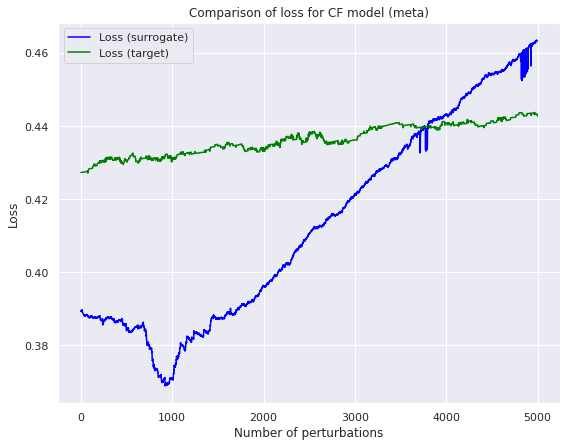

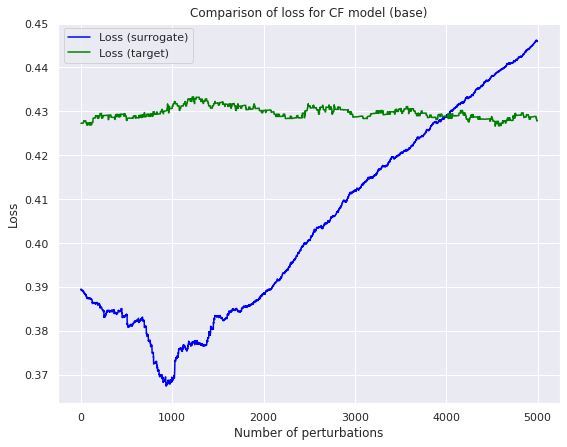

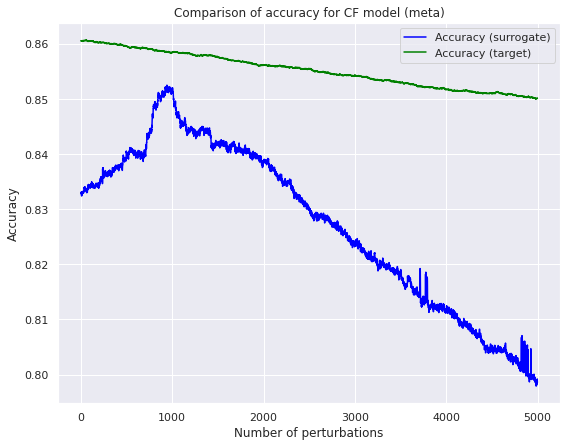

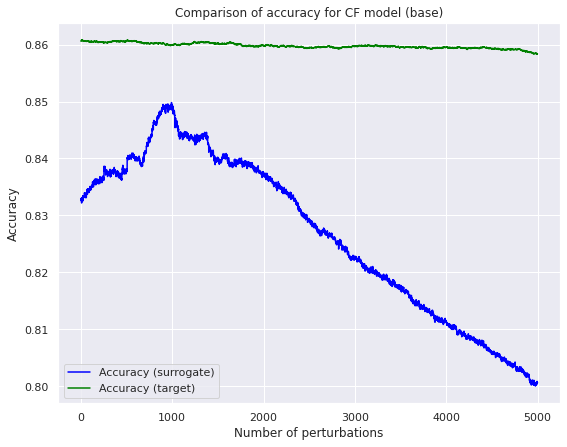

In [11]:
meta_file = 'results/old-steam/perturbations_surrogateNCF_evalCF_meta_Delta=5000_T=500_LR=40_Factors=64_auto_r.csv'
base_file = 'results/old-steam/perturbations_surrogateNCF_evalCF_baseline_Delta=5000_T=500_LR=40_Factors=64_auto_r.csv'
plot_file = 'NCF-CF'

makePlots(meta_file = meta_file, base_file = base_file, plot_file = plot_file)

#### **Surrogate NCF, Evaluation NCF, Steam, same-init**

In [13]:
# filenames
meta_file = 'results/old-steam/perturbations_surrogateNCF_evalNCF_meta_Delta=5000_T=600_LR=100_Factors=64_sameinit_auto_r.csv'
base_file = 'results/old-steam/perturbations_surrogateNCF_evalNCF_baseline_Delta=5000_T=600_LR=100_Factors=64_sameinit_auto_r.csv'

table, latex = parseResults(meta_file = meta_file, base_file = base_file)
if printLatex:
    print(latex)
table

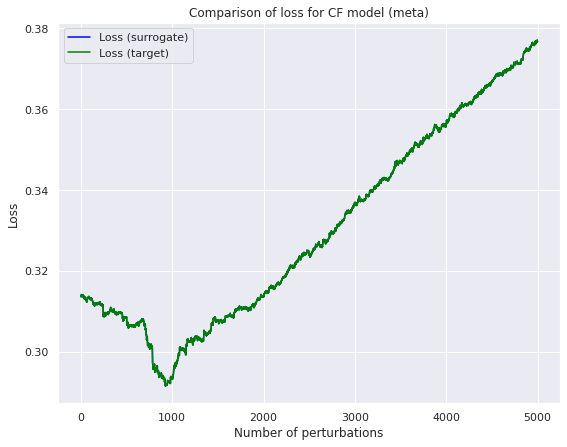

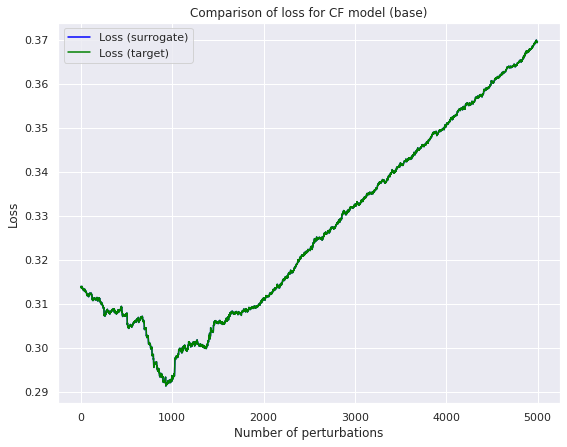

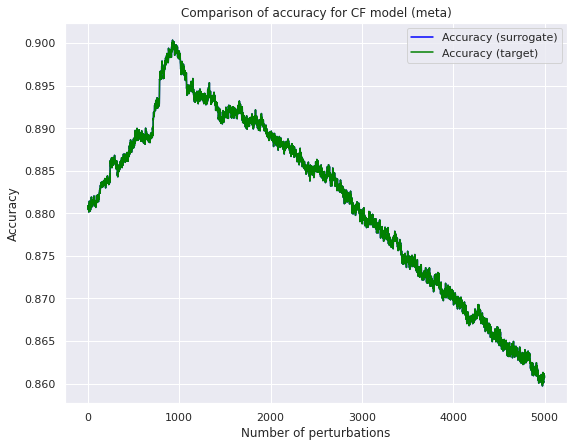

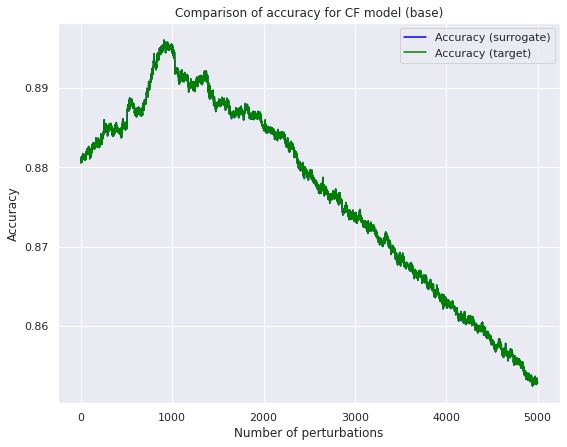

In [12]:
meta_file = 'results/old-steam/perturbations_surrogateNCF_evalNCF_meta_Delta=5000_T=600_LR=100_Factors=64_sameinit_auto_r.csv'
base_file = 'results/old-steam/perturbations_surrogateNCF_evalNCF_baseline_Delta=5000_T=600_LR=100_Factors=64_sameinit_auto_r.csv'
plot_file = 'NCF-NCF-sameinit'

makePlots(meta_file = meta_file, base_file = base_file, plot_file = plot_file)

#### **Surrogate NCF, Evaluation NCF, Steam, diff-init**

In [14]:
# filenames
meta_file = 'results/old-steam/perturbations_surrogateNCF_evalNCF_meta_Delta=5000_T=600_LR=100_Factors=64_diffinit_auto_r.csv'
base_file = 'results/old-steam/perturbations_surrogateNCF_evalNCF_baseline_Delta=5000_T=600_LR=100_Factors=64_diffinit_auto_r.csv'

table, latex = parseResults(meta_file = meta_file, base_file = base_file)
if printLatex:
    print(latex)
table

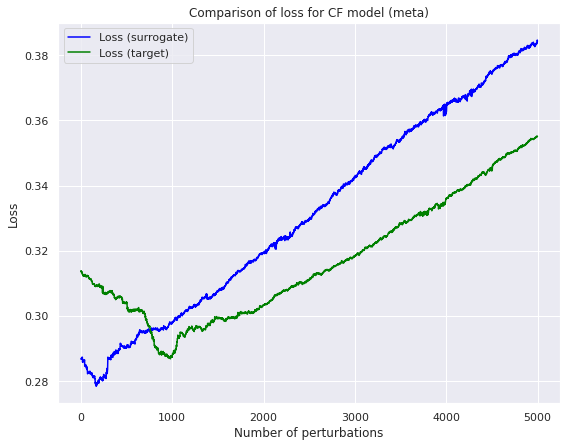

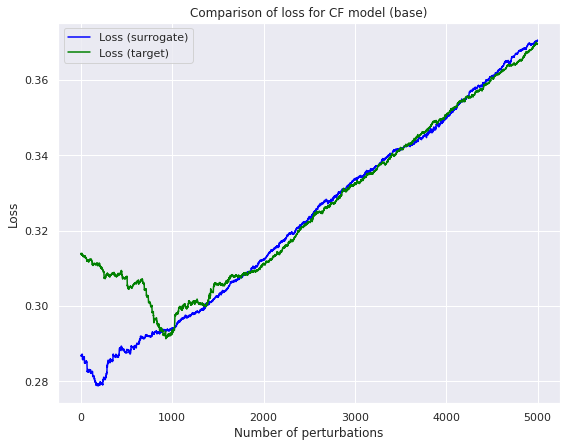

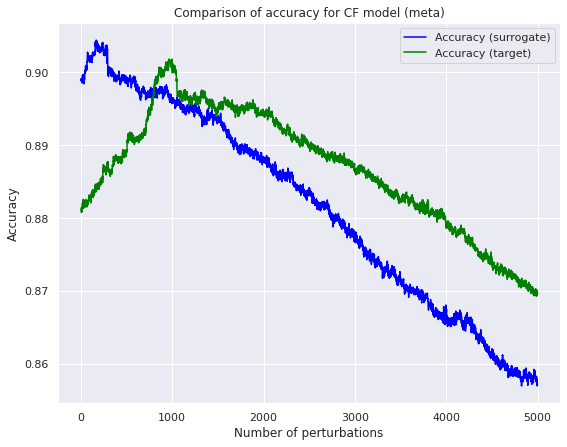

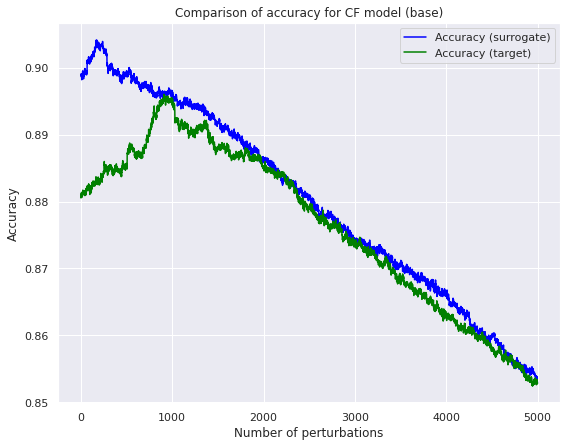

In [13]:
meta_file = 'results/old-steam/perturbations_surrogateNCF_evalNCF_meta_Delta=5000_T=600_LR=100_Factors=64_diffinit_auto_r.csv'
base_file = 'results/old-steam/perturbations_surrogateNCF_evalNCF_baseline_Delta=5000_T=600_LR=100_Factors=64_diffinit_auto_r.csv'
plot_file = 'NCF-NCF-diffinit'

makePlots(meta_file = meta_file, base_file = base_file, plot_file = plot_file)

#### **Surrogate CF, Evaluation CF, Steam, diff-init**

In [15]:
meta_file = 'results/old-steam/perturbations_surrogateCF_evalCF_meta_Delta=5000_T=500_LR=50_Factors=64_diffinit_auto_r.csv'
base_file = 'results/old-steam/perturbations_surrogateCF_evalCF_baseline_Delta=5000_T=500_LR=50_Factors=64_diffinit_auto_r.csv'

table, latex = parseResults(meta_file = meta_file, base_file = base_file)
if printLatex:
    print(latex)
table

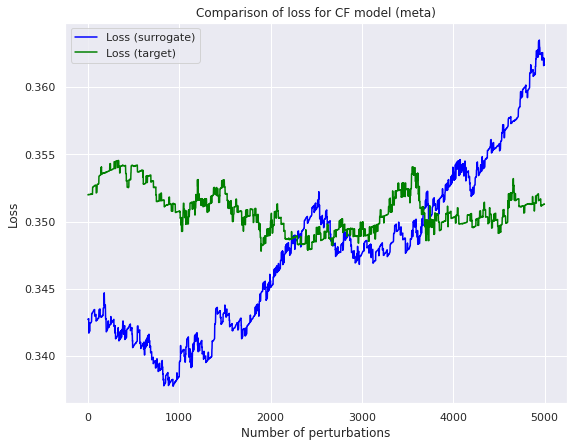

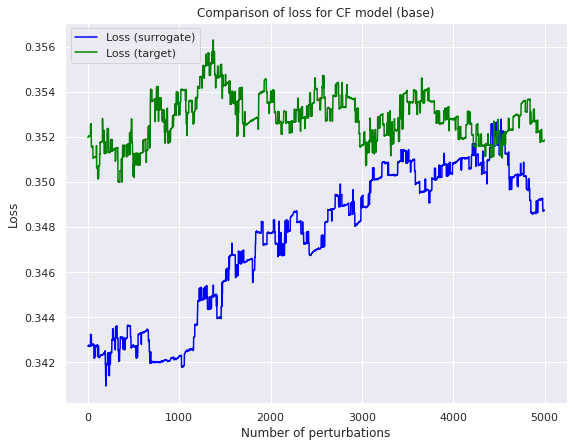

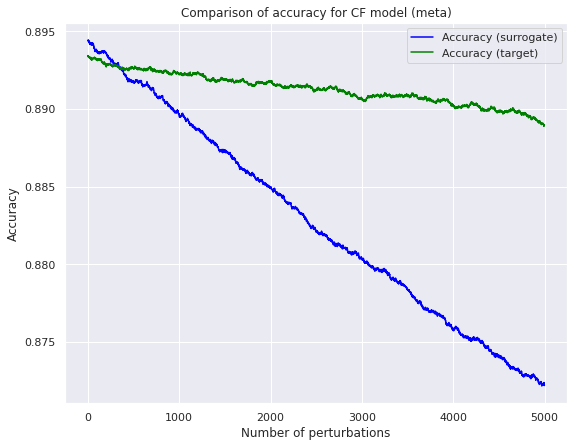

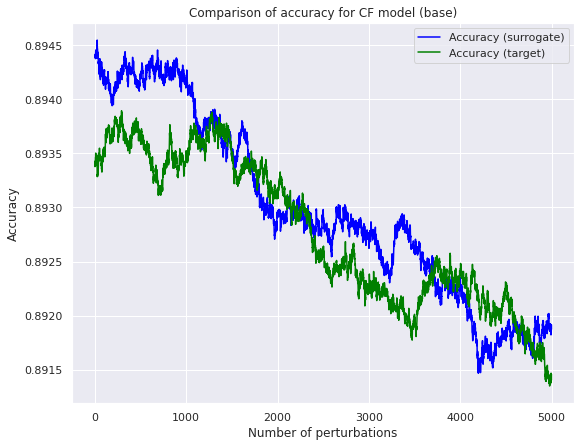

In [14]:
meta_file = 'results/old-steam/perturbations_surrogateCF_evalCF_meta_Delta=5000_T=500_LR=50_Factors=64_diffinit_auto_r.csv'
base_file = 'results/old-steam/perturbations_surrogateCF_evalCF_baseline_Delta=5000_T=500_LR=50_Factors=64_diffinit_auto_r.csv'
plot_file = 'CF-CF-diffinit'

makePlots(meta_file = meta_file, base_file = base_file, plot_file = plot_file)

#### **Surrogate CF, Evaluation NCF, Steam**

In [16]:
meta_file = 'results/old-steam/perturbations_surrogateCF_evalNCF_meta_Delta=5000_T=400_LR=100_Factors=64_auto_r.csv'
base_file = 'results/old-steam/perturbations_surrogateCF_evalNCF_baseline_Delta=5000_T=400_LR=100_Factors=64_auto_r.csv'

table, latex = parseResults(meta_file = meta_file, base_file = base_file)
if printLatex:
    print(latex)
table

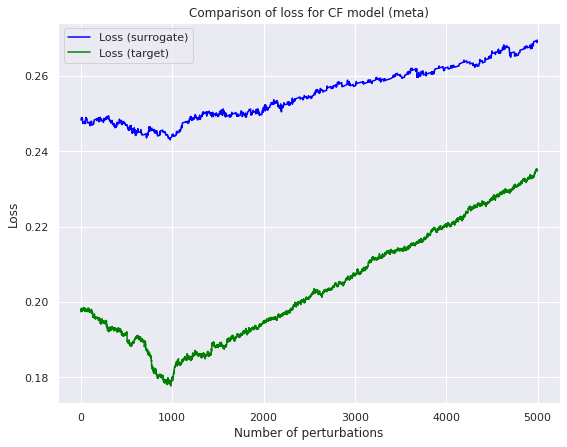

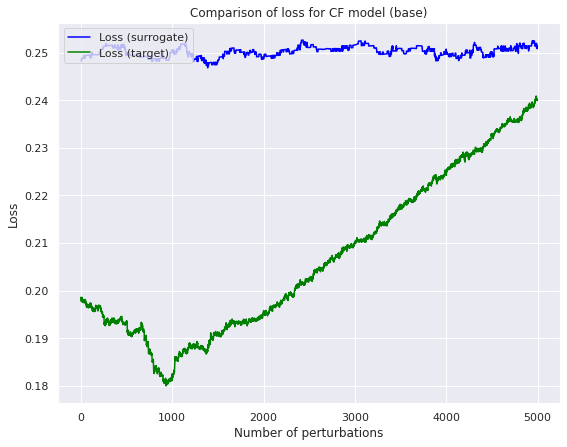

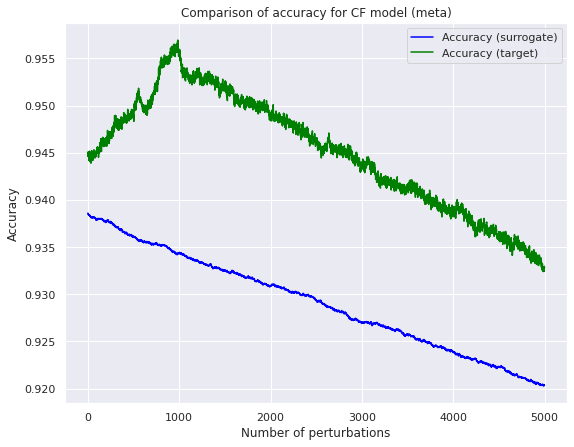

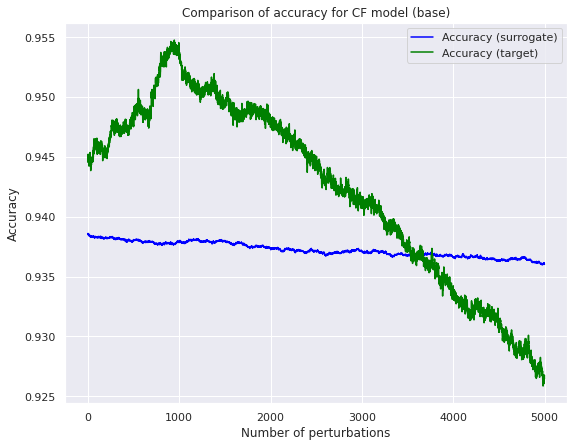

In [15]:
meta_file = 'results/old-steam/perturbations_surrogateCF_evalNCF_meta_Delta=5000_T=400_LR=100_Factors=64_auto_r.csv'
base_file = 'results/old-steam/perturbations_surrogateCF_evalNCF_baseline_Delta=5000_T=400_LR=100_Factors=64_auto_r.csv'
plot_file = 'CF-NCF'

makePlots(meta_file = meta_file, base_file = base_file, plot_file = plot_file)

#### **Surrogate CF-SGD, Evaluation CF-Adam, Steam, same-init**

In [17]:
meta_file = 'results/old-steam/perturbations_surrogateCF(SGD)_evalCF(Adam)_meta_Delta=5000_T=500_LR=50_Factors=64_sameinit_auto_r.csv'
base_file = 'results/old-steam/perturbations_surrogateCF(SGD)_evalCF(Adam)_baseline_Delta=5000_T=500_LR=50_Factors=64_sameinit_auto_r.csv'

table, latex = parseResults(meta_file = meta_file, base_file = base_file)
if printLatex:
    print(latex)
table

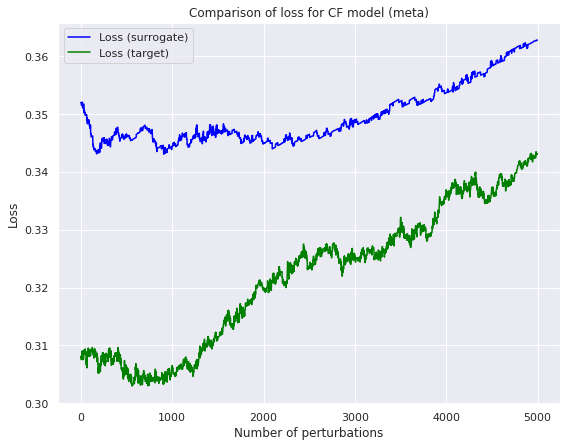

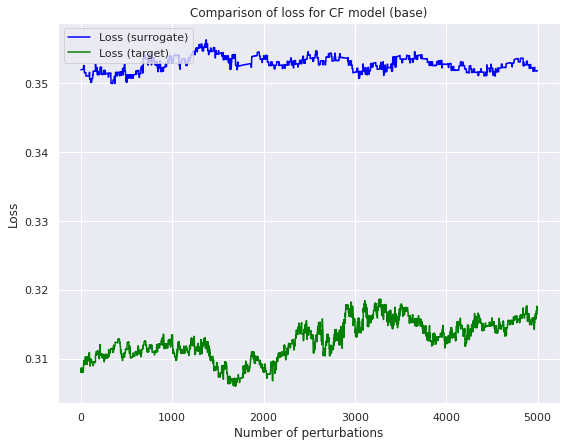

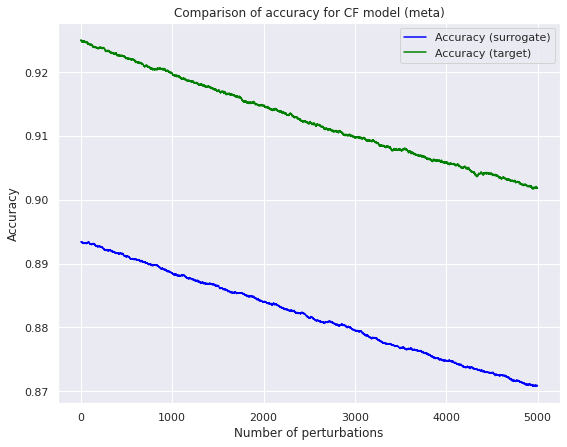

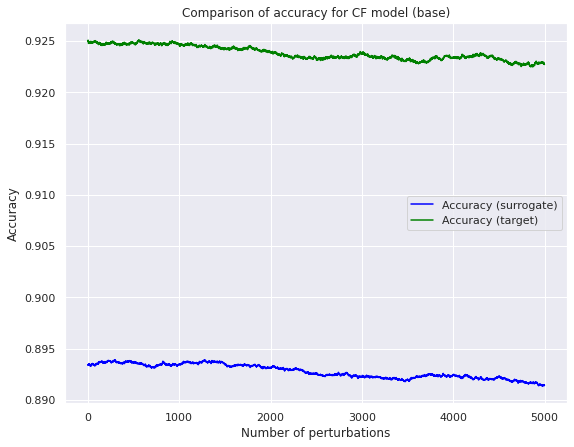

In [16]:
meta_file = 'results/old-steam/perturbations_surrogateCF(SGD)_evalCF(Adam)_meta_Delta=5000_T=500_LR=50_Factors=64_sameinit_auto_r.csv'
base_file = 'results/old-steam/perturbations_surrogateCF(SGD)_evalCF(Adam)_baseline_Delta=5000_T=500_LR=50_Factors=64_sameinit_auto_r.csv'
plot_file = 'CF(sgd)-CF(adam)-sameinit'

makePlots(meta_file = meta_file, base_file = base_file, plot_file = plot_file)

#### **Surrogate CF, Evaluation CF, Steam, same-init same-optimizer nfactors-2x**

In [18]:
meta_file = 'results/old-steam/perturbations_surrogateCF_evalCF_meta_Delta=5000_T=500_LR=50_Factors=64_sameinit_factors2x_auto_r.csv'
base_file = 'results/old-steam/perturbations_surrogateCF_evalCF_baseline_Delta=5000_T=500_LR=50_Factors=64_sameinit_factors2x_auto_r.csv'

table, latex = parseResults(meta_file = meta_file, base_file = base_file)
if printLatex:
    print(latex)
table

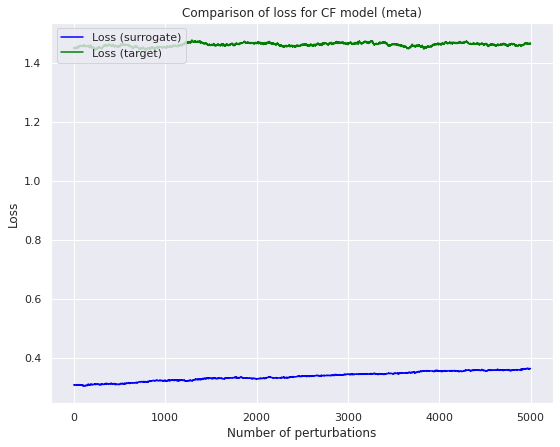

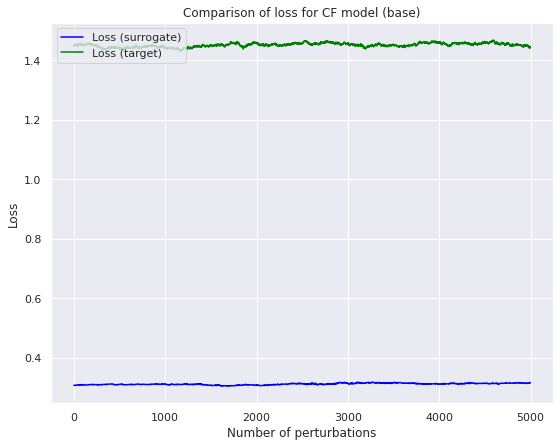

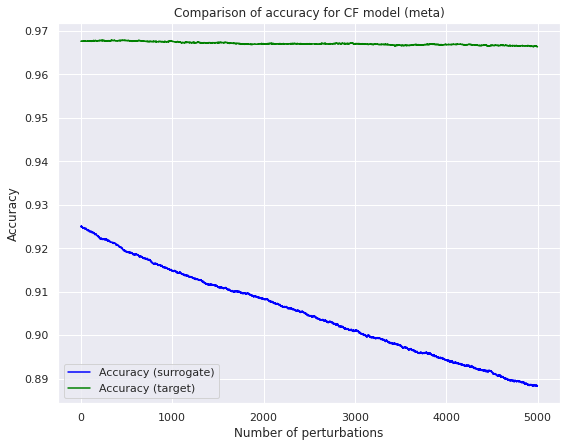

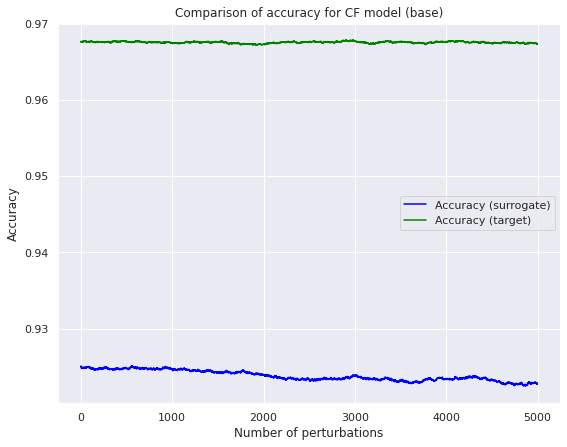

In [17]:
meta_file = 'results/old-steam/perturbations_surrogateCF_evalCF_meta_Delta=5000_T=500_LR=50_Factors=64_sameinit_factors2x_auto_r.csv'
base_file = 'results/old-steam/perturbations_surrogateCF_evalCF_baseline_Delta=5000_T=500_LR=50_Factors=64_sameinit_factors2x_auto_r.csv'
plot_file = 'CF-CF-sameinit-factors2x'

makePlots(meta_file = meta_file, base_file = base_file, plot_file = plot_file)

# **Old results**

In [3]:
perturbations = pd.read_csv('results/perturbations_baseline_Delta=10000_T=400_LR=51_Factors=64_manual_r.csv')

In [7]:
perturbations

,Unnamed: 0,edges,metagrad,accuracy_before,accuracy_after,loss_before,loss_after
0,0,177041,-1,0.864430,0.864430,0.367983,0.367983
1,1,24036,-1,0.864490,0.864494,0.367989,0.367985
2,2,189327,-1,0.864485,0.864489,0.367991,0.367987
3,3,167057,-1,0.864415,0.864423,0.368009,0.367997
4,4,94652,-1,0.864435,0.864447,0.368022,0.368007
...,...,...,...,...,...,...,...
9995,9995,187793,-1,0.847370,0.857430,0.397749,0.381324
9996,9996,85226,-1,0.847365,0.857424,0.397757,0.381331
9997,9997,14632,-1,0.847365,0.857424,0.397757,0.381331
9998,9998,142085,-1,0.847390,0.857450,0.397759,0.381332


In [13]:
perturbations[::2000][['accuracy_after', 'loss_after']]

,accuracy_after,loss_after
0,0.864430,0.367983
2000,0.862620,0.370208
4000,0.861047,0.373078
6000,0.859229,0.377565
8000,0.858784,0.380229


In [14]:
meta[::2000][['accuracy_after', 'loss_after']]

,accuracy_after,loss_after
0,0.864430,0.367983
2000,0.856833,0.371127
4000,0.849638,0.384024
6000,0.842186,0.398227
8000,0.834875,0.409323


In [8]:
meta = pd.read_csv('results/perturbations_MetaTrain_Delta=10000_T=400_LR=51_Factors=64_manual_r.csv')

In [9]:
meta

,Unnamed: 0,edges,metagrad,accuracy_before,accuracy_after,loss_before,loss_after
0,0,40063,0.000131,0.864430,0.864430,0.367983,0.367983
1,1,135373,0.000130,0.864460,0.864464,0.368070,0.367995
2,2,26320,0.000123,0.864455,0.864464,0.368141,0.367998
3,3,115985,0.000122,0.864475,0.864488,0.368207,0.367992
4,4,57873,0.000121,0.864500,0.864517,0.367822,0.367542
...,...,...,...,...,...,...,...
9995,9995,159236,0.000021,0.796480,0.828426,0.500577,0.422373
9996,9996,83237,0.000021,0.796485,0.828435,0.500593,0.422388
9997,9997,39014,0.000021,0.796480,0.828434,0.500607,0.422399
9998,9998,126325,0.000021,0.796495,0.828454,0.500628,0.422414


#### **Steam**

In [15]:
base = pd.read_csv('results/perturbations_steam_baseline_Delta=10000_T=300_LR=100_Factors=64_manual_r.csv')
base

,Unnamed: 0,edges,metagrad,accuracy_before,accuracy_after,loss_before,loss_after
0,0,106569,-1,0.913585,0.913585,0.306598,0.306598
1,1,1227,-1,0.913579,0.913579,0.306595,0.306597
2,2,52886,-1,0.913567,0.913566,0.306595,0.306598
3,3,93788,-1,0.913538,0.913536,0.306586,0.306591
4,4,143757,-1,0.913532,0.913530,0.307082,0.307089
...,...,...,...,...,...,...,...
9995,9995,139397,-1,0.906881,0.909580,0.320500,0.319834
9996,9996,21247,-1,0.906875,0.909592,0.320508,0.319844
9997,9997,142265,-1,0.906916,0.909641,0.320510,0.319842
9998,9998,115724,-1,0.906952,0.909666,0.320509,0.319844


In [16]:
meta = pd.read_csv('results/perturbations_steam_meta_Delta=10000_T=300_LR=100_Factors=64_manual_r.csv')
meta

,Unnamed: 0,edges,metagrad,accuracy_before,accuracy_after,loss_before,loss_after
0,0,85658,0.000174,0.913585,0.913585,0.306598,0.306598
1,1,105403,0.000163,0.913573,0.913579,0.306671,0.306626
2,2,96880,0.000158,0.913532,0.913543,0.306727,0.306656
3,3,124502,0.000154,0.913473,0.913489,0.306788,0.306669
4,4,58013,0.000150,0.913449,0.913470,0.306846,0.306681
...,...,...,...,...,...,...,...
9995,9995,131129,0.000030,0.858530,0.874909,0.388090,0.356909
9996,9996,104427,0.000030,0.858536,0.874940,0.387579,0.356365
9997,9997,157554,0.000033,0.858506,0.874927,0.387595,0.356376
9998,9998,84849,0.000030,0.858488,0.874913,0.387601,0.356384


In [20]:
base[::][['accuracy_after', 'loss_after']]

,accuracy_after,loss_after
0,0.913585,0.306598
1,0.913579,0.306597
2,0.913566,0.306598
3,0.913536,0.306591
4,0.913530,0.307089
...,...,...
9995,0.909580,0.319834
9996,0.909592,0.319844
9997,0.909641,0.319842
9998,0.909666,0.319844


In [21]:
meta[::][['accuracy_after', 'loss_after']]

,accuracy_after,loss_after
0,0.913585,0.306598
1,0.913579,0.306626
2,0.913543,0.306656
3,0.913489,0.306669
4,0.913470,0.306681
...,...,...
9995,0.874909,0.356909
9996,0.874940,0.356365
9997,0.874927,0.356376
9998,0.874913,0.356384


#### **Netflix**

In [23]:
base = pd.read_csv('results/perturbations_netflix_baseline_Delta=2000_T=100_LR=10000_Factors=64_manual_r.csv')
base

,Unnamed: 0,edges,metagrad,accuracy_before,accuracy_after,loss_before,loss_after
0,0,1074697,-1,0.841843,0.841843,0.354682,0.354682
1,1,214001,-1,0.841829,0.841830,0.354689,0.354689
2,2,644455,-1,0.841851,0.841852,0.354662,0.354661
3,3,3258140,-1,0.841842,0.841843,0.354668,0.354668
4,4,896552,-1,0.841826,0.841826,0.354686,0.354685
...,...,...,...,...,...,...,...
1995,1995,817889,-1,0.841730,0.842077,0.355397,0.354457
1996,1996,2707600,-1,0.841724,0.842071,0.355399,0.354457
1997,1997,2872478,-1,0.841717,0.842064,0.355407,0.354465
1998,1998,6356,-1,0.841722,0.842069,0.355387,0.354444


In [24]:
meta = pd.read_csv('results/perturbations_netflix_meta_Delta=2000_T=100_LR=10000_Factors=64_manual_r.csv')
meta

,Unnamed: 0,edges,metagrad,accuracy_before,accuracy_after,loss_before,loss_after
0,0,1223808,0.000006,0.841843,0.841843,0.354682,0.354682
1,1,2178286,0.000006,0.841847,0.841848,0.354672,0.354668
2,2,1624784,0.000006,0.841820,0.841821,0.354710,0.354701
3,3,1799168,0.000005,0.841826,0.841827,0.354709,0.354697
4,4,2061428,0.000005,0.841819,0.841820,0.354719,0.354703
...,...,...,...,...,...,...,...
1995,1995,245798,0.000003,0.841199,0.841705,0.360304,0.355606
1996,1996,3077242,0.000003,0.841196,0.841703,0.360305,0.355606
1997,1997,2276642,0.000003,0.841190,0.841697,0.360309,0.355608
1998,1998,1380977,0.000003,0.841190,0.841697,0.360311,0.355607


In [29]:
base[::][['accuracy_after', 'loss_after']]

,accuracy_after,loss_after
0,0.841843,0.354682
1,0.841830,0.354689
2,0.841852,0.354661
3,0.841843,0.354668
4,0.841826,0.354685
...,...,...
1995,0.842077,0.354457
1996,0.842071,0.354457
1997,0.842064,0.354465
1998,0.842069,0.354444


In [28]:
meta[::][['accuracy_after', 'loss_after']]

,accuracy_after,loss_after
0,0.841843,0.354682
1,0.841848,0.354668
2,0.841821,0.354701
3,0.841827,0.354697
4,0.841820,0.354703
...,...,...
1995,0.841705,0.355606
1996,0.841703,0.355606
1997,0.841697,0.355608
1998,0.841697,0.355607


#### **Anime**

In [ ]:
base = pd.read_csv('results/perturbations_anime_baseline_Delta=10000_T=300_LR=200_Factors=64_manual_r.csv')
meta = pd.read_csv('results/perturbations_anime_meta_Delta=10000_T=300_LR=200_Factors=64_manual_r.csv')

In [8]:
base[::][['accuracy_after', 'loss_after']]

,accuracy_after,loss_after
0,0.863191,0.327948
1,0.863169,0.327953
2,0.863186,0.327954
3,0.863190,0.327952
4,0.863185,0.327950
...,...,...
9995,0.859784,0.335836
9996,0.859821,0.335837
9997,0.859818,0.335835
9998,0.859771,0.335839


In [7]:
meta[::][['accuracy_after', 'loss_after']]

,accuracy_after,loss_after
0,0.863191,0.327948
1,0.863157,0.327951
2,0.863154,0.327954
3,0.863152,0.327960
4,0.863130,0.327960
...,...,...
9995,0.832773,0.385796
9996,0.832797,0.385789
9997,0.832804,0.385790
9998,0.832801,0.385800


#### **Approx**

In [30]:
approx = pd.read_csv('results/perturbations_approx_Delta=1000_T=400_LR=51_Factors=64_manual_r.csv')
approx

,Unnamed: 0,edges,metagrad,accuracy_before,accuracy_after,loss_before,loss_after
0,0,26320,0.054895,0.864430,0.864430,0.367983,0.367983
1,1,40063,0.054168,0.864455,0.864459,0.368049,0.367976
2,2,103855,0.053329,0.864460,0.864469,0.367717,0.367568
3,3,135373,0.052735,0.864475,0.864488,0.367798,0.367563
4,4,57873,0.050566,0.864445,0.864462,0.368289,0.367986
...,...,...,...,...,...,...,...
995,995,160871,0.024799,0.857635,0.861898,0.387287,0.362672
996,996,69718,0.024790,0.857585,0.861852,0.387306,0.362670
997,997,184688,0.024785,0.857630,0.861902,0.387327,0.362682
998,998,29653,0.024780,0.857620,0.861896,0.387345,0.362683


In [32]:
base = pd.read_csv('results/perturbations_baseline_Delta=10000_T=400_LR=51_Factors=64_manual_r.csv')
base

,Unnamed: 0,edges,metagrad,accuracy_before,accuracy_after,loss_before,loss_after
0,0,177041,-1,0.864430,0.864430,0.367983,0.367983
1,1,24036,-1,0.864490,0.864494,0.367989,0.367985
2,2,189327,-1,0.864485,0.864489,0.367991,0.367987
3,3,167057,-1,0.864415,0.864423,0.368009,0.367997
4,4,94652,-1,0.864435,0.864447,0.368022,0.368007
...,...,...,...,...,...,...,...
9995,9995,187793,-1,0.847370,0.857430,0.397749,0.381324
9996,9996,85226,-1,0.847365,0.857424,0.397757,0.381331
9997,9997,14632,-1,0.847365,0.857424,0.397757,0.381331
9998,9998,142085,-1,0.847390,0.857450,0.397759,0.381332


In [34]:
meta = pd.read_csv('results/perturbations_MetaTrain_Delta=10000_T=400_LR=51_Factors=64_manual_r.csv')
meta

,Unnamed: 0,edges,metagrad,accuracy_before,accuracy_after,loss_before,loss_after
0,0,40063,0.000131,0.864430,0.864430,0.367983,0.367983
1,1,135373,0.000130,0.864460,0.864464,0.368070,0.367995
2,2,26320,0.000123,0.864455,0.864464,0.368141,0.367998
3,3,115985,0.000122,0.864475,0.864488,0.368207,0.367992
4,4,57873,0.000121,0.864500,0.864517,0.367822,0.367542
...,...,...,...,...,...,...,...
9995,9995,159236,0.000021,0.796480,0.828426,0.500577,0.422373
9996,9996,83237,0.000021,0.796485,0.828435,0.500593,0.422388
9997,9997,39014,0.000021,0.796480,0.828434,0.500607,0.422399
9998,9998,126325,0.000021,0.796495,0.828454,0.500628,0.422414


In [41]:
base[:1001:200][['accuracy_after', 'loss_after']]

,accuracy_after,loss_after
0,0.864430,0.367983
200,0.864570,0.367199
400,0.864544,0.367556
600,0.863977,0.368961
800,0.863817,0.369355
1000,0.863756,0.369761


In [38]:
approx[::200][['accuracy_after', 'loss_after']]

,accuracy_after,loss_after
0,0.864430,0.367983
200,0.864034,0.366818
400,0.863617,0.365512
600,0.863019,0.363863
800,0.862560,0.363393


In [42]:
meta[:1001:200][['accuracy_after', 'loss_after']]

,accuracy_after,loss_after
0,0.864430,0.367983
200,0.863679,0.365422
400,0.863111,0.365359
600,0.862432,0.365086
800,0.861677,0.366105
1000,0.860854,0.367071


In [43]:
approx[['accuracy_after', 'loss_after']]

,accuracy_after,loss_after
0,0.864430,0.367983
1,0.864459,0.367976
2,0.864469,0.367568
3,0.864488,0.367563
4,0.864462,0.367986
...,...,...
995,0.861898,0.362672
996,0.861852,0.362670
997,0.861902,0.362682
998,0.861896,0.362683
